# Bayesian Hyperparameter Optimization on the Titanic Dataset

Let's apply our methods for Bayesian Hyperparameter Optimization on Kaggles Titanic dataset: https://www.kaggle.com/c/titanic

This notebook is created with docker-stacks: https://github.com/jupyter/docker-stacks

In [1]:
%%init_spark
# Configure Spark to use a local master
launcher.master = "local"
launcher.jars = ["/home/jovyan/jars/assembly.jar"]

In [2]:
sc.version

Intitializing Scala interpreter ...

Spark Web UI available at http://593395768e60:4041
SparkContext available as 'sc' (version = 2.4.7, master = local, app id = local-1609670113028)
SparkSession available as 'spark'


res0: String = 2.4.7


In [3]:
%%python
import matplotlib
matplotlib.use("agg")
from matplotlib import pyplot as plt
from IPython.display import Image
import tempfile
import numpy as np

## Load data

We download the titanic train set, process it and split it into 5 random groups for crossvalidation.

In [4]:
import sys.process._
import java.net.URL
import java.io.File
new URL("http://s3.amazonaws.com/assets.datacamp.com/course/Kaggle/train.csv") #> new File("titanic.csv") !!

import sys.process._
import java.net.URL
import java.io.File
res1: String = ""


In [5]:
import org.apache.spark.sql.types.{DoubleType, StringType}

import org.apache.spark.sql.types.{DoubleType, StringType}


In [6]:
val dataWithNulls = {
    spark.read.option("header", true).csv("titanic.csv")
        .repartition(1)
        .withColumn("survived", $"Survived".cast(DoubleType))
        .withColumn("age", $"Age".cast(DoubleType))
        .withColumn("siblings_spouses", $"SibSp".cast(DoubleType))
        .withColumn("parents_children", $"Parch".cast(DoubleType))
        .withColumn("fare", $"Fare".cast(DoubleType))
        .select($"survived", $"Name" as "passenger_name", $"Pclass" as "passenger_class", $"Sex" as "sex",
                $"age", $"fare", $"siblings_spouses", $"parents_children")
        .withColumn("split", abs(hash($"passenger_name")) % 5)
        .cache
}
val meanAge = dataWithNulls.select(mean("age")).first.getDouble(0)
val data = dataWithNulls.withColumn("age", coalesce($"age", lit(meanAge)))
data.show(5, false)

+--------+---------------------------------------------------+---------------+------+----+-------+----------------+----------------+-----+
|survived|passenger_name                                     |passenger_class|sex   |age |fare   |siblings_spouses|parents_children|split|
+--------+---------------------------------------------------+---------------+------+----+-------+----------------+----------------+-----+
|0.0     |Braund, Mr. Owen Harris                            |3              |male  |22.0|7.25   |1.0             |0.0             |1    |
|1.0     |Cumings, Mrs. John Bradley (Florence Briggs Thayer)|1              |female|38.0|71.2833|1.0             |0.0             |4    |
|1.0     |Heikkinen, Miss. Laina                             |3              |female|26.0|7.925  |0.0             |0.0             |1    |
|1.0     |Futrelle, Mrs. Jacques Heath (Lily May Peel)       |1              |female|35.0|53.1   |1.0             |0.0             |3    |
|0.0     |Allen, Mr. Willia

dataWithNulls: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [survived: double, passenger_name: string ... 7 more fields]
meanAge: Double = 29.69911764705882
data: org.apache.spark.sql.DataFrame = [survived: double, passenger_name: string ... 7 more fields]


In [7]:
data.printSchema

root
 |-- survived: double (nullable = true)
 |-- passenger_name: string (nullable = true)
 |-- passenger_class: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = false)
 |-- fare: double (nullable = true)
 |-- siblings_spouses: double (nullable = true)
 |-- parents_children: double (nullable = true)
 |-- split: integer (nullable = true)



We make sure that the splits look okay.

In [8]:
val n = data.count
(0 until 5).foreach(split => {
    val splitData = data.where($"split" === split)
    val splitCount = splitData.count
    val splitSurvived = splitData.where($"survived" === 1d).count
    println(s"Split $split, size: $splitCount, survived: $splitSurvived")
})

Split 0, size: 190, survived: 76
Split 1, size: 177, survived: 67
Split 2, size: 179, survived: 75
Split 3, size: 177, survived: 62
Split 4, size: 168, survived: 62


n: Long = 891


## Build ML Pipeline

Let's quickly build a machine learing pipeline with a random forest classifier.

In [9]:
import org.apache.spark.ml.classification.RandomForestClassifier
import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator
import org.apache.spark.ml.feature.{OneHotEncoderEstimator, SQLTransformer, StringIndexer, VectorAssembler}
import org.apache.spark.ml.Pipeline

import org.apache.spark.ml.classification.RandomForestClassifier
import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator
import org.apache.spark.ml.feature.{OneHotEncoderEstimator, SQLTransformer, StringIndexer, VectorAssembler}
import org.apache.spark.ml.Pipeline


In [10]:
/** Transformer to get the title of a passenger if followed by a dot. */
val titleTransformer = new SQLTransformer("title").setStatement(
    s"""
         |SELECT *
         |, CASE WHEN passenger_name LIKE '%\\.%' THEN split(passenger_name, '\\\\.')[0]
         |       ELSE 'Nothing'
         |  END AS passenger_title
         |FROM __THIS__
      """.stripMargin
)

titleTransformer: org.apache.spark.ml.feature.SQLTransformer = title


In [11]:
/** We one-hot encode categorical columns */
val categoricalCols = Array("passenger_class", "sex", "passenger_title")
val indexCols = categoricalCols.map(_ + "_index")
val oheCols = categoricalCols.map(_ + "_ohe")
val stringIndexers = categoricalCols.map(cc => {
    new StringIndexer(s"string_indexer_$cc")
        .setHandleInvalid("keep")
        .setInputCol(cc)
        .setOutputCol(cc + "_index")
})
val oneHotEncoder = {
    new OneHotEncoderEstimator("ohe")
        .setHandleInvalid("keep")
        .setDropLast(false)
        .setInputCols(indexCols)
        .setOutputCols(oheCols)
}

categoricalCols: Array[String] = Array(passenger_class, sex, passenger_title)
indexCols: Array[String] = Array(passenger_class_index, sex_index, passenger_title_index)
oheCols: Array[String] = Array(passenger_class_ohe, sex_ohe, passenger_title_ohe)
stringIndexers: Array[org.apache.spark.ml.feature.StringIndexer] = Array(string_indexer_passenger_class, string_indexer_sex, string_indexer_passenger_title)
oneHotEncoder: org.apache.spark.ml.feature.OneHotEncoderEstimator = ohe


In [12]:
val numericalCols = Array("age", "fare", "siblings_spouses", "parents_children")
val vectorAssembler = {
    new VectorAssembler("vector_assembler")
        .setInputCols(oheCols ++ numericalCols)
        .setOutputCol("features")
}

numericalCols: Array[String] = Array(age, fare, siblings_spouses, parents_children)
vectorAssembler: org.apache.spark.ml.feature.VectorAssembler = vector_assembler


In [13]:
val rawClassifier = {
    new RandomForestClassifier("rf")
        .setSeed(20201124L)
        .setFeaturesCol("features")
        .setLabelCol("survived")
        .setProbabilityCol("survival_prob")
        .setRawPredictionCol("survival_raw_pred")
}

rawClassifier: org.apache.spark.ml.classification.RandomForestClassifier = rf


We will use sparks BinaryClassificationEvaluator to get the area under the ROC.

In [14]:
val evalAuc = {
    new BinaryClassificationEvaluator()
        .setLabelCol("survived")
        .setRawPredictionCol("survival_raw_pred")
}

evalAuc: org.apache.spark.ml.evaluation.BinaryClassificationEvaluator = binEval_082cd0195006


## Setup Bayesian Optimization

In [15]:
import com.agoda.ml.spark.hpopt.BayesianHyperparameterOptimization
import com.agoda.ml.spark.hpopt.hyperparam._
import com.agoda.ml.spark.hpopt.gaussian._
import org.apache.spark.sql.DataFrame

import com.agoda.ml.spark.hpopt.BayesianHyperparameterOptimization
import com.agoda.ml.spark.hpopt.hyperparam._
import com.agoda.ml.spark.hpopt.gaussian._
import org.apache.spark.sql.DataFrame


We add some tunable hyperparameters of the RandomForestClassifier to the hyperparameter space.

In [16]:
val hpSpace = HyperparameterSpace(Array(
    CategoricalHyperparameterType("impurity", Seq("entropy", "gini")),
    IntHyperparameterType("maxDepth", LinearScale(2, 10)),
    IntHyperparameterType("numTrees", LogScale(3, 20)),
    DoubleHyperparameterType("minInfoGain", LinearScale(0, 0.3))
))

hpSpace: com.agoda.ml.spark.hpopt.hyperparam.HyperparameterSpace = HyperparameterSpace([Lcom.agoda.ml.spark.hpopt.hyperparam.HyperparameterType;@27f28e96,None)


Now, we are ready to create an instance of BayesianHyperparameterOptimization, the main entry point to the algorithm. Here we can set all the options like the hyperparameter space, the Gaussian Process Kernel, the acquisition function, how many Monte Carlo steps we want to take to evaluate the acquisition function and if we want to maximize or minimize. We will go with the default options and only set our hyperparameter space and maximize to true.

In [17]:
val bho = new BayesianHyperparameterOptimization(
    hpSpace,
    seed = Some(24112020),
    maximize = true
)

bho: com.agoda.ml.spark.hpopt.BayesianHyperparameterOptimization = com.agoda.ml.spark.hpopt.BayesianHyperparameterOptimization@bc6d773


As the data set is very small, we will use cross validation for evaluating the metric for each hyperparameter setting.

In [18]:
def crossValid(hp: HyperparameterEvalPoint): Double = {
    
    // Set the new hyperparameters to the classifier
    val classifier: RandomForestClassifier = hp.copyPipelineStage(rawClassifier) match {case rfc: RandomForestClassifier => rfc}
    
    val aucSeq = (0 until 5).toSeq.map(split => {
        
        val train = data.where($"split" =!= split)
        val eval = data.where($"split" === split)
        
        val pipeline = new Pipeline("pipeline").setStages(Array(titleTransformer) ++ stringIndexers ++ Array(oneHotEncoder, vectorAssembler, classifier))
        
        // Fit and evaluate the model with updated hyperparameters
        evalAuc.evaluate(pipeline.fit(train).transform(eval))
    })
    
    aucSeq.sum / 5
}

crossValid: (hp: com.agoda.ml.spark.hpopt.hyperparam.HyperparameterEvalPoint)Double


The framework gives us full control over each evaluation step. The BayesianHyperparameterOptimization instance only provides us with a recommendation of the next hyperparameter values to evaluate, the rest is up to the end user.

In [19]:
// This function will take care of the tuning process and return a DataFrame with all tuning steps
def tune(
    iterations: Int,
    randomIterations: Int = 0,
    preExistentHP: Array[HyperparameterEvalPoint] = Array.empty[HyperparameterEvalPoint],
    preExistentMetrics: Array[Double] = Array.empty[Double]
): DataFrame = {
    
    // This is a tail recursive function for each iteration step
    def iterationStep(
        step: Int,
        previousHP: Array[HyperparameterEvalPoint],
        previousMetrics: Array[Double]
    ): (Array[HyperparameterEvalPoint], Array[Double]) = {

        // Depending on the step count we determine the next hyperparameters to evaluate randomly or by Bayesian Optimization
        val nextHP = if (step < randomIterations) bho.getNextRandom else bho.getNext(previousHP, previousMetrics)

        // Evaluate the hyperparameters using the cross validation function
        val nextMetric = crossValid(nextHP)

        // We append our new values to the existing arrays
        val allHP = previousHP :+ nextHP
        val allMetrics = previousMetrics :+ nextMetric

        // Depending on the step count we execute another step or return the arrays of hyperparameters and metrics
        if (step < iterations - 1) iterationStep(step + 1, allHP, allMetrics)
        else (allHP, allMetrics)
    }
    
    // Run the loop starting from 0
    val (allHP, allMetrics) = iterationStep(0, preExistentHP, preExistentMetrics)
    
    //Return the iterations as a DataFrame
    hpSpace.createDF(allHP, allMetrics, "auc")(spark.sqlContext)
}    

tune: (iterations: Int, randomIterations: Int, preExistentHP: Array[com.agoda.ml.spark.hpopt.hyperparam.HyperparameterEvalPoint], preExistentMetrics: Array[Double])org.apache.spark.sql.DataFrame


## Run Bayesian Optimization

Everything is set up, now we can run the tuning and display our results.

In [20]:
import org.apache.spark.sql.expressions.Window

import org.apache.spark.sql.expressions.Window


We go for 50 iterations including 5 random iterations to start with.

In [21]:
val bayesianEvaluations = tune(iterations = 50, randomIterations = 5)

bayesianEvaluations: org.apache.spark.sql.DataFrame = [impurity__0: string, maxDepth__1: int ... 4 more fields]


In [22]:
bayesianEvaluations.show(50, false)

+-----------+-----------+-----------+---------------------+------------------+-----+
|impurity__0|maxDepth__1|numTrees__2|minInfoGain__3       |auc               |order|
+-----------+-----------+-----------+---------------------+------------------+-----+
|entropy    |9          |4          |0.20553962166591674  |0.5               |0    |
|gini       |2          |11         |0.1494590297809831   |0.5513157894736842|1    |
|gini       |3          |6          |0.0338527449266661   |0.6028874262613682|2    |
|gini       |2          |18         |0.045028919663607156 |0.8135835043451214|3    |
|entropy    |9          |17         |0.2636275470895306   |0.5               |4    |
|entropy    |2          |20         |0.01197981858608066  |0.8277718842449037|5    |
|gini       |10         |20         |0.024937920101527733 |0.828835055120107 |6    |
|gini       |10         |3          |0.29963324055898305  |0.5               |7    |
|entropy    |2          |3          |0.0011472754196543034|0.6066

Let's create 50 random iterations as a baseline to compare to.

In [23]:
val randomEvaluations = tune(iterations = 50, randomIterations = 50)

randomEvaluations: org.apache.spark.sql.DataFrame = [impurity__0: string, maxDepth__1: int ... 4 more fields]


Now, we can compare both tuning processes in a table and a graph.

In [24]:
val evaluations = bayesianEvaluations.select($"order", $"auc" as "bayesian_auc").join(
    randomEvaluations.select($"order", $"auc" as "random_auc"),
    Seq("order"),
    "inner"
).orderBy("order").
    withColumn("bayesian_auc_cum_max", max("bayesian_auc") over (Window.orderBy("order"))).
    withColumn("random_auc_cum_max", max("random_auc") over (Window.orderBy("order")))

evaluations: org.apache.spark.sql.DataFrame = [order: int, bayesian_auc: double ... 3 more fields]


In [25]:
evaluations.show(50, false)

+-----+------------------+------------------+--------------------+------------------+
|order|bayesian_auc      |random_auc        |bayesian_auc_cum_max|random_auc_cum_max|
+-----+------------------+------------------+--------------------+------------------+
|0    |0.5               |0.5               |0.5                 |0.5               |
|1    |0.5513157894736842|0.5617959372114497|0.5513157894736842  |0.5617959372114497|
|2    |0.6028874262613682|0.5513157894736842|0.6028874262613682  |0.5617959372114497|
|3    |0.8135835043451214|0.5               |0.8135835043451214  |0.5617959372114497|
|4    |0.5               |0.5               |0.8135835043451214  |0.5617959372114497|
|5    |0.8277718842449037|0.5               |0.8277718842449037  |0.5617959372114497|
|6    |0.828835055120107 |0.6507829739955672|0.828835055120107   |0.6507829739955672|
|7    |0.5               |0.7739117192512308|0.828835055120107   |0.7739117192512308|
|8    |0.606672903523858 |0.5               |0.8288350

In [26]:
evaluations.createOrReplaceTempView("evaluations")

In [27]:
%%python
evaluations = np.array(spark.sql("select order, bayesian_auc_cum_max, random_auc_cum_max from evaluations").collect())
evaluations_order = evaluations[:,0]
evaluations_bayesian = evaluations[:,1]
evaluations_random = evaluations[:,2]

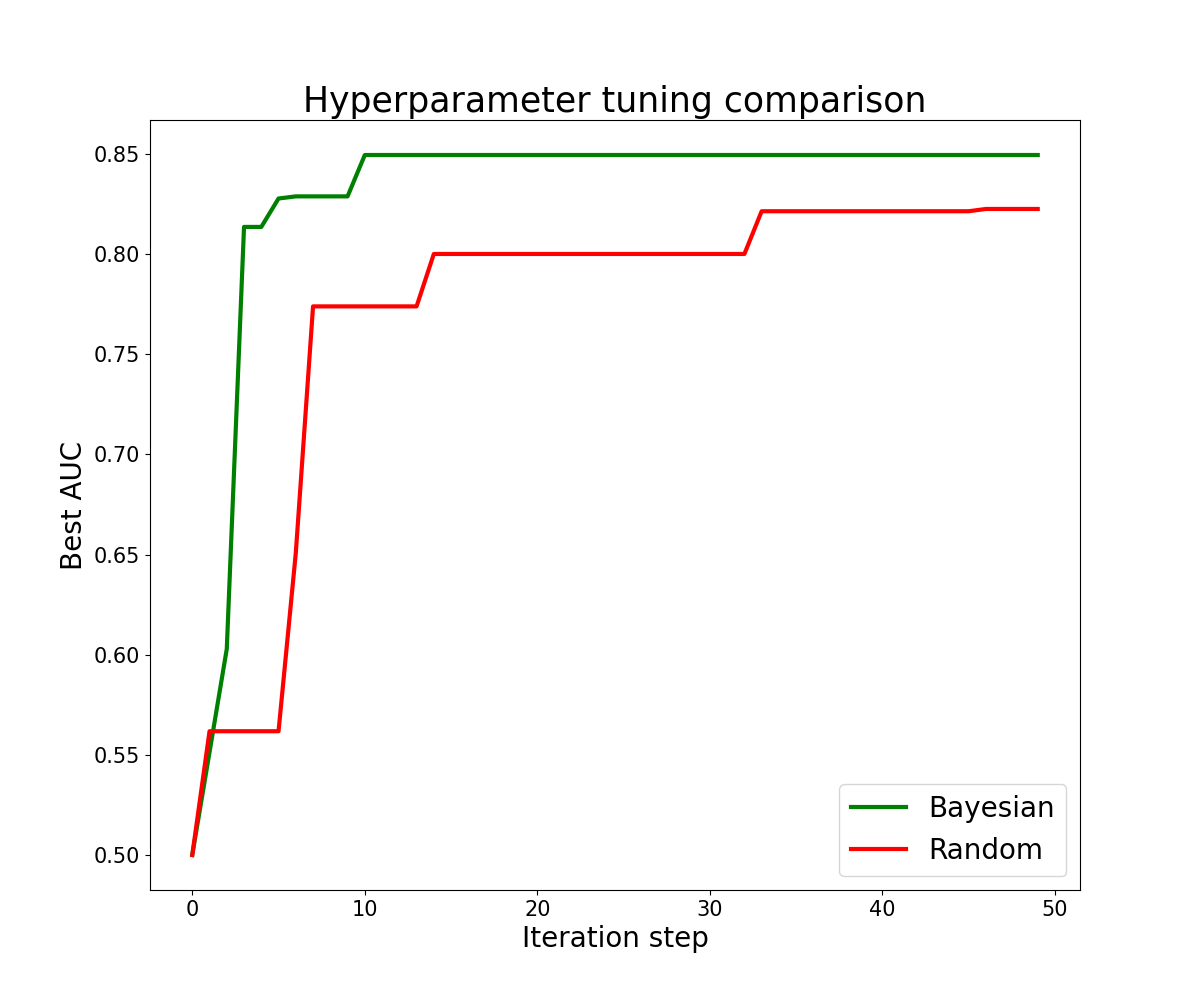

In [28]:
%%python
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(1,1,1)
ax.plot(evaluations_order, evaluations_bayesian, color='g', linewidth=3)
ax.plot(evaluations_order, evaluations_random, color='r', linewidth=3)
ax.set_title("Hyperparameter tuning comparison", fontsize=25)
ax.set_xlabel("Iteration step", fontsize=20)
ax.set_ylabel("Best AUC", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend(["Bayesian", "Random"], prop={'size': 20})
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    fig.savefig(fo.name)
    retval = Image(filename=fo.name)